In [1]:
import numpy as np
import keras
from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


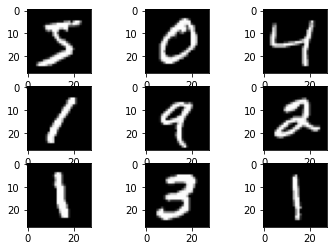

In [3]:
from matplotlib import pyplot as plt

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
img_rows, img_cols=28, 28

x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols)
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print(len(y_train))
print(len(y_test))
x_train.shape[1]


60000
10000


784

# Defining network

In [6]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=1, keepdims=True)
    

class network():
    def __init__(self, num_input_neurons, num_hidden_neurons, num_out_neurons):
        def init_weights(input_neurons, output_neurons):
            # Use Glorot/Xavier initialization
            limit = np.sqrt(6 / float(input_neurons + output_neurons))
            return np.random.uniform(low=-limit, high=limit, size=(input_neurons, output_neurons))
        
        self.w0 = init_weights(num_input_neurons, num_hidden_neurons)
        self.w1 = init_weights(num_hidden_neurons, num_out_neurons)
        
        self.b0 = np.zeros(num_hidden_neurons, dtype=float)
        self.b1 = np.zeros(num_out_neurons, dtype=float)
    
    def forward(self, x, save_x = True):
        x = np.matmul(x, self.w0) + self.b0
        if save_x:
            self.saved_x0 = x.copy()
        x = relu(x)
        if save_x:
            self.saved_x1 = x.copy()
        x = np.matmul(x, self.w1) + self.b1
        x = softmax(x)
        return x
    
# test
test_out = network(x_train.shape[1], 100, 10).forward(x_train[0:8])
assert test_out.shape == (8, 10)
        
        

### Training functions:

In [7]:
def der_relu(x):
    return np.where(x > 0.0, 1, 0)

def calc_cross_entropy(y_true, y_predicted):
    return np.mean(-np.sum(y_true * np.log(y_predicted), axis=1))

def backward_prop(network, x_train, y_predicted, y_true, lr):
    def pshape(var, name):
        print("{}.shape = {}".format(name, var.shape))
    out_error = (y_predicted - y_true) / x_train.shape[0]
    hidden_error = np.matmul(out_error, network.w1.T) * der_relu(network.saved_x0)
    
    network.w1 -= lr * np.matmul(network.saved_x1.T, out_error)
    network.b1 -= lr * np.sum(out_error, axis=0)
    network.w0 -= lr * np.matmul(x_train.T, hidden_error)
    network.b0 -= lr * np.sum(hidden_error, axis=0)

def calc_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

def evaluate(network, x_train, y_train):
    y_pred = network.forward(x_train, save_x=False)
    loss = calc_cross_entropy(y_train, y_pred)
    acc = calc_accuracy(y_train, y_pred)
    return loss, acc

In [8]:
from datetime import datetime

def train(network, x_train, y_train, x_test, y_test, epochs=20, lr=0.1, batch_size=8):
        print('Начало обучения...')
        start = datetime.now()
        for epoch in range(epochs):
            epoch_start = datetime.now()
            for i in range(x_train.shape[0] // batch_size):
                begin_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, y_train.shape[0])
                
                y_pred = network.forward(x_train[begin_idx:end_idx])
                backward_prop(network, x_train[begin_idx:end_idx], y_pred, y_train[begin_idx:end_idx], lr)

            epoch_end = datetime.now()
            epoch_time = (epoch_end - epoch_start).total_seconds()
            loss, acc = evaluate(network, x_train, y_train)
            print('Эпоха #{}, время эпохи = {} сек, Accuracy = {}%, Loss = {}'.format(epoch + 1, epoch_time, acc * 100, loss))
        end = datetime.now()
        training_time = (end - start).total_seconds()
        print('Обучение завершено за {} сек!'.format(training_time))

# Experiment

### Hyper parameters

In [9]:
hidden_layer_num = 300
lr = 0.1
num_classes = 10
batch_size = 64
epochs_num = 20

In [10]:
net = network(x_train.shape[1], hidden_layer_num, num_classes)
train(net, x_train, y_train, x_test, y_test, epochs=epochs_num, lr=lr, batch_size=batch_size)

Начало обучения...
Эпоха #1, время эпохи = 1.611894 сек, Accuracy = 93.44666666666667%, Loss = 0.2238037495930919
Эпоха #2, время эпохи = 1.55939 сек, Accuracy = 95.48666666666666%, Loss = 0.15467616281535054
Эпоха #3, время эпохи = 1.560094 сек, Accuracy = 96.55%, Loss = 0.12050700438700702
Эпоха #4, время эпохи = 1.593822 сек, Accuracy = 97.21666666666667%, Loss = 0.09805331638633323
Эпоха #5, время эпохи = 1.536918 сек, Accuracy = 97.67333333333333%, Loss = 0.08219064213866425
Эпоха #6, время эпохи = 1.548225 сек, Accuracy = 98.01666666666667%, Loss = 0.0705462749822503
Эпоха #7, время эпохи = 1.554531 сек, Accuracy = 98.26333333333334%, Loss = 0.062163698813955996
Эпоха #8, время эпохи = 1.54749 сек, Accuracy = 98.47333333333333%, Loss = 0.05525504245887687
Эпоха #9, время эпохи = 1.53743 сек, Accuracy = 98.64500000000001%, Loss = 0.04962045232148958
Эпоха #10, время эпохи = 1.575999 сек, Accuracy = 98.79666666666667%, Loss = 0.04503096993197459
Эпоха #11, время эпохи = 1.613751 се

In [11]:
loss, acc = evaluate(net, x_test, y_test)
print('Была достигнута точность {}% и loss {} на тестовом наборе данных'.format(acc * 100, loss))

Была достигнута точность 97.95% и loss 0.06769829815414127 на тестовом наборе данных
